In [ ]:
import pandas as pd
import random, nltk, re, requests, wordfreq
import numpy as np
from itertools import permutations
from IPython.display import display

# Search Functions

In [ ]:
def get_positive_permutations(val_str_pos):
    vec_ors = []
    for permutation_chars in list(permutations(val_str_pos)):
        vec_strs = ['['+x+']+[a-z]*' for x in list(permutation_chars)]
        val_strs = ''.join(vec_strs)
        vec_ors.append(val_strs)
    return('|'.join(vec_ors))

In [ ]:
def get_positive_pattern(vec_pattern_desc):
    vec_pattern = []
    if(len(vec_pattern_desc)!=5):
        print('WARNING: The pattern was not a vector length of 5...')
        vec_pattern_desc = ['*']*5
    for i in vec_pattern_desc:
        tmp_i = i.strip()
        if(tmp_i==''):
            vec_pattern.append('[a-z]')
        else:
            vec_pattern.append(tmp_i)
    return(''.join(vec_pattern))

In [ ]:
def get_negative_pattern(vec_pattern_desc):
    vec_pattern = []
    if(len(vec_pattern_desc)==5):
        for i in vec_pattern_desc:
            tmp_i = i.strip()
            if(tmp_i==''):
                vec_pattern.append('[a-z]')
            else:
                vec_pattern.append('[^'+tmp_i+']')
    else:
        print('WARNING: The pattern was not a vector of length 5...')
    return(''.join(vec_pattern))

In [ ]:
def get_matches(val_chars_pos,val_chars_ptrn_pos,val_chars_neg,val_chars_ptrn_neg,df_w,val_word_len=5,val_cutoff=50,is_freq_sort=True):
    val_chars_pos = val_chars_pos.strip().lower()
    val_chars_neg = val_chars_neg.strip().lower()
    val_chars_pos_exp = get_positive_permutations(val_chars_pos)
    val_chars_ptrn_exp_pos = get_positive_pattern(val_chars_ptrn_pos)
    val_chars_ptrn_exp_neg = get_negative_pattern(val_chars_ptrn_neg)

    if(val_chars_neg==''):
        vec_srch_neg = [True]*df_w.shape[0]
    else:
        vec_srch_neg = ~np.array([True if re.search(r'[a-z]*[{chars_neg}]+[a-z]*'.format(chars_neg=val_chars_neg),x) else False for x in df_w['word']])
    vec_srch_pos = np.array([True if re.search(r'[a-z]*{chars_pos}'.format(chars_pos=val_chars_pos_exp),x) else False for x in df_w['word']])
    vec_srch_ptrn_pos = np.array([True if re.search(val_chars_ptrn_exp_pos,x) else False for x in df_w['word']])
    vec_srch_ptrn_neg = np.array([True if re.search(val_chars_ptrn_exp_neg,x) else False for x in df_w['word']])
        
    df_1 = df_w.loc[(vec_srch_neg) & (vec_srch_pos) & (vec_srch_ptrn_pos) & (vec_srch_ptrn_neg)].copy()
    df_2 = df_w.loc[(vec_srch_neg) & (vec_srch_pos) & (vec_srch_ptrn_pos) & (vec_srch_ptrn_neg) & (df_w['letters_uniq']==5)].copy()
    print('All words matching criteria (includes words without 5 unique letters; {tot} total):'.format(tot=df_1.shape[0]))
    val_str = '\n'+'-'*35+'\nOnly words with 5 unique letters ({tot} total):'.format(tot=df_2.shape[0])
    if(df_1.shape[0]>val_cutoff):
        print(', '.join(df_1['word']))
    else:
        if('freq' in df_1.columns and is_freq_sort):
            df_1.sort_values(by=['freq'],inplace=True)
        display(df_1)
    print(val_str)
    if(df_2.shape[0]>val_cutoff):
        print(', '.join(df_2['word']))
    else:
        if('freq' in df_2.columns and is_freq_sort):
            df_2.sort_values(by=['freq'],inplace=True)
        display(df_2)

# Latin Words

In [ ]:
url_text = '''https://scipython.com/static/media/uploads/blog/wordle/latin-5-words.txt'''
val_response = requests.get(url_text)
val_raw_data = val_response.content
print(type(val_raw_data))

In [ ]:
val_data_00 = val_raw_data.decode('utf-8')
vec_words_scipy = val_data_00.split('\n')

In [ ]:
#Obtained from https://personal.math.ubc.ca/~cass/frivs/latin/latin-dict-full.html
f = open('./words_latin.txt','r')
val_data_00 = f.readlines()
print(len(val_data_00))
df_words_ubc = pd.DataFrame({'definition':val_data_00})
print(df_words_ubc.shape)

In [ ]:
df_words_ubc['word'] = df_words_ubc['definition'].str.strip()
df_words_ubc['word'] = df_words_ubc['word'].str.lower()
df_words_ubc['is_word'] = [' : ' in str(x) for x in df_words_ubc['word']]
df_words_ubc['word'] = [x.split(' : ')[0] for x in df_words_ubc['word']]
df_words_ubc['src'] = 'UBC'
df_words = pd.concat([df_words_ubc,pd.DataFrame({'word':vec_words_scipy,'is_word':[True]*len(vec_words_scipy),'src':['SciPy']*len(vec_words_scipy)})])
df_words['word'] = df_words['word'].str.strip()
df_words['word'] = df_words['word'].str.lower()
print(df_words.shape)
df_words['word_len'] = df_words['word'].apply(len)
df_words.tail()

In [ ]:
print('Before Deduplication, Total Words = '+str(df_words.shape[0]))
df_words = df_words.loc[df_words['is_word']==True].copy()
print(df_words.shape)
print('After Deduplication, Total Words = '+str(df_words.shape[0]))

# English Words
Using NLTK, take all of the English words and calculate their sum.

In [ ]:
vec_words = nltk.corpus.words.words()

In [ ]:
%%time
df_words = pd.DataFrame({'word':vec_words})
df_words['word'] = df_words['word'].str.lower()
df_words['word'] = df_words['word'].str.strip()
df_words['word_len'] = df_words['word'].apply(len)

In [ ]:
print('Before Deduplication, Total Words = '+str(df_words.shape[0]))
df_words.drop_duplicates(subset=['word'],inplace=True)
print('After Deduplication, Total Words = '+str(df_words.shape[0]))

# Cleanup

In [9]:
#Identify the number of unique letters in each 5 letter word
print(df_words.shape[0])
df_words_subset_5 = df_words.loc[df_words['word_len']==5].copy()
df_words_subset_5['letters_uniq'] = [len(set(x)) for x in df_words_subset_5['word']]
print(df_words_subset_5.shape[0])

234377
9972


# Apply Frequencies

In [10]:
df_words_subset_5['freq'] = [wordfreq.word_frequency(x,'en') for x in df_words_subset_5['word']]

<AxesSubplot:>

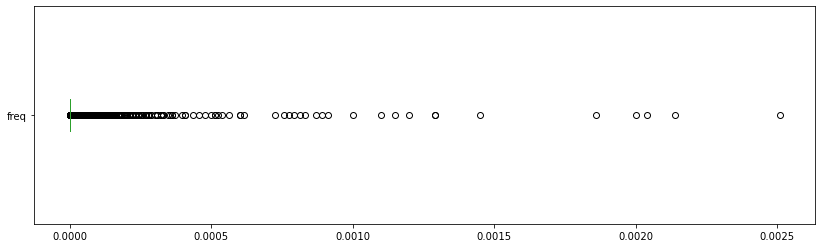

In [11]:
df_words_subset_5['freq'].plot.box(figsize=(14,4),vert=False)

In [12]:
print('25% =',df_words_subset_5['freq'].quantile(q=0.25))
print('30% =',df_words_subset_5['freq'].quantile(q=0.3))
print('35% =',df_words_subset_5['freq'].quantile(q=0.35))
print('65% =',df_words_subset_5['freq'].quantile(q=0.65))
print('75% =',df_words_subset_5['freq'].quantile(q=0.75))
print('85% =',df_words_subset_5['freq'].quantile(q=0.85))
print('95% =',df_words_subset_5['freq'].quantile(q=0.95))

25% = 0.0
30% = 0.0
35% = 1.17e-08
65% = 2.14e-07
75% = 7.08e-07
85% = 3.02e-06
95% = 2.51e-05


<AxesSubplot:ylabel='Density'>

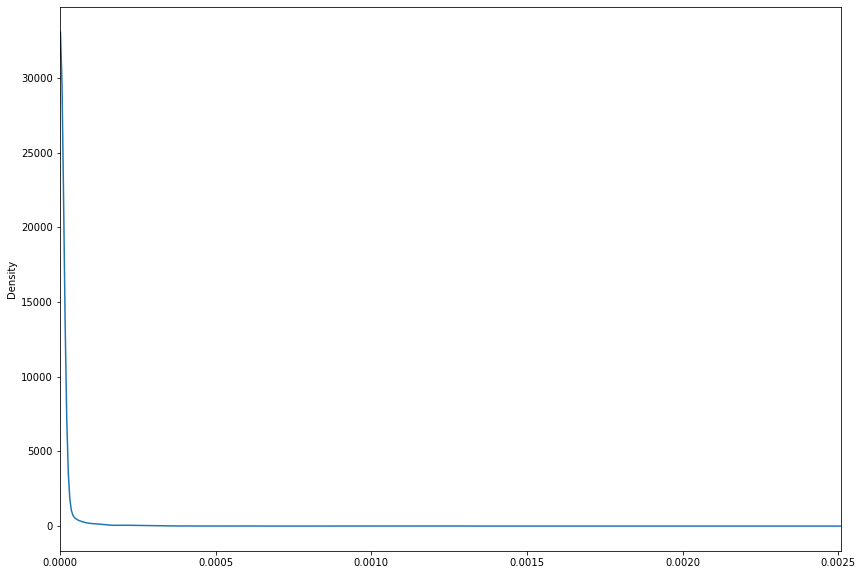

In [13]:
df_words_subset_5['freq'].plot.kde(figsize=(14,10),xlim=(0,df_words_subset_5['freq'].max()))

# Strategy
## Step 1
A good starting strategy is to pick any word that has 5 unique characters, this way you can identify letters that should be in the word or not in the word quickly and with maximum options.  Repeating characters does not provide any benefit to identify the letters that are correct, unless you randomly guess repeating characters in the exact index location for the word - which is highly unlikely at the beginning.

Within Step 1 there are two substrategies to be considered: (1) show any random word from the collection of words and (2) show only words that have a relatively high frequncy of occurrence.  To state the second substrategy in different terms: eliminate words that are extremely uncommon as they would be less likely to be chosen given the ability for players to know them is lower given their relative frequency.

In [ ]:
df_words_subset_5.loc[df_words_subset_5['letters_uniq']==5].sample()

In [ ]:
df_words_subset_5.loc[df_words_subset_5['freq']>=df_words_subset_5['freq'].quantile(q=0.35)].sample()

## Step 2:
Using the information obtained after the first submission and for all subsequent submissions, provide the letters that are identified to:
- Exist in the word, but the position is unclear (e.g., if you know the letter 'a' is in the word); this could be anywhere in the word as well as letters in specific locations.
- Exists in the word and you know the specific index location where it exists (e.g., the second letter is a 'h').
- Does not exist in the word (e.g., the letter 'k' is not in the word).

In order to make these patterns work, the `val_pos` and `val_neg` are strings of characters.  For example, if the word is known to have the letters 'a', 'b', and 'h' then `val_pos = 'abh'` in any order.  The same would apply for `val_neg`; if the word was known to not have the letters 'j', 'k', or 'l' then `val_neg = 'jkl'`.  The `val_ptrn_pos` should always be a vector that has a length of five (5) elements of characters sequences; a blank (e.g., `''`) is considered a wild card; if a letter is known to have an index, replace the `''` with the letter.  For example, if the 'h' character is known to exist in the third position, then `val_ptrn_pos = ['','','h','','']`.  The `val_ptrn_neg` has been implemented in a similar fashion as a vector that has a length of five (5) elements of character sequences.  For example, if the word is known not to have 'h' or 'a' at the third index position, then `val_ptrn_neg = ['','','ha','','']`.

The function for finding the recommended words has an option to sort the results based on the calculated frequency from the library `wordfreq`.

In [ ]:
val_pos = 'aum'
val_neg = 'nof'
val_ptrn_pos = ['','u','','','']
val_ptrn_neg = ['a','','','au','sm']

get_matches(val_chars_pos=val_pos,
            val_chars_ptrn_pos=val_ptrn_pos,
            val_chars_neg=val_neg,
            val_chars_ptrn_neg=val_ptrn_neg,
            df_w=df_words_subset_5)